
# Computing LLPR uncertainties

This tutorial demonstrates how to use an already trained and exported model
from Python. It involves the computation of the local prediction rigidity
([LPR](LPR_)) for every atom of a single ethanol molecule, using the
last-layer prediction rigidity ([LLPR](LLPR_)) approximation.


The model was trained using the following training options.

.. literalinclude:: options.yaml
   :language: yaml

You can train the same model yourself with

.. literalinclude:: train.sh
   :language: bash

A detailed step-by-step introduction on how to train a model is provided in
the `label_basic_usage` tutorial.


In [1]:
import torch
from metatensor.torch.atomistic import load_atomistic_model

Exported models can be loaded using the `load_atomistic_model` function from the
metatensor.torch.atomistic` module. The function requires the path to the exported
model and, for many models, also the path to the respective extensions directory.
Both are produced during the training process.



In [2]:
model = load_atomistic_model("model.pt", extensions_directory="extensions/")
model = model.to("cpu")

In metatrain, a Dataset is composed of a list of systems and a dictionary of targets.
The following lines illustrate how to read systems and targets from xyz files, and
how to create a Dataset object from them.



In [3]:
from metatrain.utils.data import Dataset, read_systems, read_targets  # noqa: E402
from metatrain.utils.neighbor_lists import get_system_with_neighbor_lists  # noqa: E402
import omegaconf


qm9_systems = read_systems("ethanol_reduced_100.xyz", dtype=torch.float64)

target_config = {
    "energy": {
        "quantity": "energy",
        "read_from": "ethanol_reduced_100.xyz",
        "file_format": ".xyz",
        "key": "energy",
        "unit": "kcal/mol",
        "forces": {
            "read_from": "ethanol_reduced_100.xyz",
            "key": "forces",
            "file_format": ".xyz",
        },
        "stress": False,
        "virial": False,
    },
}
targets, target_info = read_targets(target_config, dtype=torch.float64)

requested_neighbor_lists = model.requested_neighbor_lists()
qm9_systems = [
    get_system_with_neighbor_lists(system, requested_neighbor_lists)
    for system in qm9_systems
]
dataset = Dataset({"system": qm9_systems, **targets})

# We also load a single ethanol molecule on which we will compute properties.
# This system is loaded without targets, as we are only interested in the LPR
# values.
ethanol_system = read_systems("ethanol_reduced_100.xyz", dtype=torch.float64)[0]
ethanol_system = get_system_with_neighbor_lists(
    ethanol_system, requested_neighbor_lists
)

The dataset is fully compatible with torch. For example, be used to create
a DataLoader object.



In [4]:
from metatrain.utils.data import collate_fn  # noqa: E402


dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=False,
    collate_fn=collate_fn,
)

In [5]:
ll_params = []
for name, param in model.named_parameters():
    if "last_layers" in name and "weight" in name:
        ll_params.append(param)
print(len(ll_params))

4


We now wrap the model in a LLPRUncertaintyModel object, which will allows us
to compute prediction rigidity metrics, which are useful for uncertainty
quantification and model introspection.



In [9]:
from metatensor.torch.atomistic import (  # noqa: E402
    MetatensorAtomisticModel,
    ModelMetadata,
)

from metatrain.utils.llpr import LLPRUncertaintyModel  # noqa: E402


llpr_model = LLPRUncertaintyModel(model)
llpr_model.eval()
# llpr_model.compute_covariance(dataloader)

from metatrain.utils.loss import TensorMapDictLoss
loss_fn = TensorMapDictLoss(
    weights={
        "energy": 1.0,
        "energy_positions_gradients": 0.0,
    },
    reduction="sum"
)

llpr_model.compute_covariance_as_pseudo_hessian(dataloader, target_info, loss_fn, ll_params)
print(llpr_model.covariance)

llpr_model.compute_inverse_covariance()

# calibrate on the same dataset for simplicity. In reality, a separate
# calibration/validation dataset should be used.
llpr_model.calibrate(dataloader)

exported_model = MetatensorAtomisticModel(
    llpr_model.eval(),
    ModelMetadata(),
    llpr_model.capabilities,
)

tensor([[ 6.1554e+10, -1.9105e+11,  1.6567e+11,  ..., -3.8915e+10,
         -4.0176e+10,  7.7346e+10],
        [-1.9105e+11,  5.9509e+11, -5.1658e+11,  ...,  1.2133e+11,
          1.2518e+11, -2.4106e+11],
        [ 1.6567e+11, -5.1658e+11,  4.4873e+11,  ..., -1.0540e+11,
         -1.0869e+11,  2.0935e+11],
        ...,
        [-3.8915e+10,  1.2133e+11, -1.0540e+11,  ...,  2.4764e+10,
          2.5530e+10, -4.9173e+10],
        [-4.0176e+10,  1.2518e+11, -1.0869e+11,  ...,  2.5530e+10,
          2.6336e+10, -5.0716e+10],
        [ 7.7346e+10, -2.4106e+11,  2.0935e+11,  ..., -4.9173e+10,
         -5.0716e+10,  9.7679e+10]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


We can now use the model to compute the LPR for every atom in the ethanol molecule.
To do so, we create a ModelEvaluationOptions object, which is used to request
specific outputs from the model. In this case, we request the uncertainty in the
atomic energy predictions.



In [26]:
from metatensor.torch.atomistic import ModelEvaluationOptions, ModelOutput  # noqa: E402


evaluation_options = ModelEvaluationOptions(
    length_unit="angstrom",
    outputs={
        # request the uncertainty in the atomic energy predictions
        "mtt::aux::energy_uncertainty": ModelOutput(per_atom=True),
        # `per_atom=False` would return the total uncertainty for the system,
        # or (the inverse of) the TPR (total prediction rigidity)
        # you also can request other outputs from the model here, for example:
        # "energy": ModelOutput(per_atom=True),
        # "mtt::aux::last_layer_features": ModelOutput(per_atom=True),
    },
    selected_atoms=None,
)

outputs = exported_model([ethanol_system], evaluation_options, check_consistency=True)
lpr = outputs["mtt::aux::energy_uncertainty"].block().values.detach().cpu().numpy()

We can now visualize the LPR values using the `plot_atoms` function from
``ase.visualize.plot``.



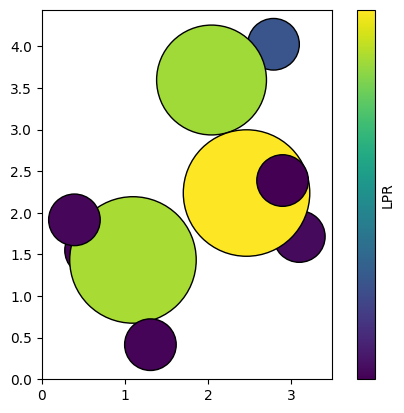

In [27]:
import ase.io  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
from ase.visualize.plot import plot_atoms  # noqa: E402
from matplotlib.colors import LogNorm  # noqa: E402


structure = ase.io.read("ethanol_reduced_100.xyz")
norm = LogNorm(vmin=min(lpr), vmax=max(lpr))
colormap = plt.get_cmap("viridis")
colors = colormap(norm(lpr))
ax = plot_atoms(structure, colors=colors, rotation="180x,0y,0z")
custom_ticks = [1e10, 2e10, 5e10, 1e11, 2e11]
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=colormap),
    ax=ax,
    label="LPR",
    ticks=custom_ticks,
)
cbar.ax.set_yticklabels([f"{tick:.0e}" for tick in custom_ticks])
cbar.minorticks_off()
plt.show()

In [ ]:
# missing: test that the two covariances are the same!
# code to do force uncertainties (probably external)